In [1]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler


from sklearn import metrics

import warnings
warnings.simplefilter('ignore')

## File name and other important parameters like ngram_range set

In [2]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:\\Users\\574977\\PycharmProjects\\pepsico\\RPA_work\\FSHA - RPA.xlsx"
#n_components = 0

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) - Q1

In [3]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [4]:
fsha_data = pd.read_excel(filename)

In [5]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Row6_Nuts,Row6_Peanuts,Row6_Soya,Row6_Celery,Row6_Lupin,Row6_Molluscs,Row6_Mustard,Row6_Sesame Seeds,Row6_Sulphites,Allergens_to_be_labeled (concatenated value from the rows)
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36559-FSHA-in process (Phase 1 Indian pellet l...,Simba Shapes Next Gen,36559,"Simba Shapes - Playz, Simba Shapes Twistz",Breakthrough - South Africa & Nigeria,Purchase an existing Pellet spec used by Pepsi...,unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes - Playz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes Twistz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Accolade Blend Flex project FSHA 5.4.1 + FS in...,Oil BlendFlex - HOSO,#44720,Lays and Simba Ruffles,Business continuation &/or Productivity,Validate a new oil blend for Lays and Simba to...,Lays and Simba Ruffles,Lizel Laubscher,ESSA,SSA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
fsha_data.columns

Index(['File Name', ' projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       'Current TSG Stage', 'FSAssessors', 'FSDate', 'WHTD', 'manufacSite',
       'PlantTrial', 'packMaterial', 'CPD-ProdName', 'CPD-ProdName-Desc',
       'procPlat', 'intrinsicProd', 'preservatives', 'pH', 'waterActivity',
       'packaging', 'otherFSA', 'allergens', 'prodStorageDist', 'shelfLife',
       'TCG', 'foodSafetyProdClaims', 'cookedOrHeated', 'specificStorage',
       'labelingInstructions ', 'mishandled', 'targetMarket', 'fastTrack',
       'baseProduct', 'prodModifications', 'newIngredient', 'approvedPackage',
       'potentialMicrobial', 'crossContactAllergens', 'chokeHazard',
       'operationalAllergen'],
      dtype='object')

In [6]:
#Check few categorical values
fsha_data[['cookedOrHeated', 'specificStorage']]

,cookedOrHeated,specificStorage
0,No,No
1,No,Ambient Storage
2,No,Ambient Storage
3,No,Ambient Storage
4,No,"Yes, do not store after opening"
5,no,no
6,"NO, RTE",N/A ambient
7,na,na
8,No,No
9,no,no


# Based on Analysis select the Features (X)

In [7]:
#selecting set of columns as Features
data2=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','cookedOrHeated', 'specificStorage']]


# Standardize Categorical Columns (those columns which have values in a fixed set, ex: packaging) - Q 1

In [8]:
#ph value label
data2['PH_label']=data2['pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
data2['PH_label']=data2['PH_label'].apply(lambda x:ph_process(x))    
    
#'specificStorage'column label
print("specificStorage from extract")
def specificStorage(x):
    x=str(x.lower())
    print(x)
    if x.__contains__('do not store'):
        return 'do not store open product'
    elif x.__contains__('ambient')  :
        return 'ambient storage'
    elif x.__contains__('no')  :
        return 'no'
    else:
        return 'NA'
data2['specificStorage_label']=data2['specificStorage'].apply(lambda x:specificStorage(x))   
print("specificStorage after transformation")
print(data2['specificStorage_label'])

#'cookedorHeated'column label
def cookedOrHeated(x):
    x=str(x.lower())
    #print(x)
    if x.__contains__('no'):
        return 'no'
    elif x.__contains__('ready to eat')  :
        return 'no'
    else:
        return 'NA'
data2['cookedOrHeated_label']=data2['cookedOrHeated'].apply(lambda x:cookedOrHeated(x))    
#print(data2['cookedOrHeated_label'])

#'prod_storageDist'column label
print("prod_storageDist from extract")
def prod_storageDist(x):
    
    x=str(x.lower())
    print(x)
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
data2['prod_storageDist_label']=data2['prodStorageDist'].apply(lambda x:prod_storageDist(x))      
print("prod_storageDist after transformation")
print(data2['prod_storageDist_label'])

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
data2['waterActivity_label']=data2['waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
print("packaging from extract")
def packaging(x):
    x=str(x)
    x=x.lower()
    print(x)
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
    
data2['packaging_label']=data2['packaging'].apply(lambda x: packaging(x))  
print("packaging after data transformation")
print(data2['packaging_label'])
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
data2['preservatives_label']=data2['preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
data2['otherFSA_label']=data2['otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a',x)):
        return 'NA'
    else:
        return(x)

data2['foodSafety_prodClaims_label']=data2['foodSafetyProdClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
data2['targetMarket_label']=data2['targetMarket'].apply(lambda x:targetMarket(x))



specificStorage from extract
no
ambient storage
ambient storage
ambient storage
yes, do not store after opening
no
n/a ambient
na
no
no
no
do not store open product
no
specificStorage after transformation
0                            no
1               ambient storage
2               ambient storage
3               ambient storage
4     do not store open product
5                            no
6               ambient storage
7                            NA
8                            no
9                            no
10                           no
11    do not store open product
12                           no
Name: specificStorage_label, dtype: object
prod_storageDist from extract
store in a dry, cool and away from sun place.
ambient 
ambient 
ambient 
rte
ambient
ambient, rte
silo
store in a dry, cool and away from sun place.
ambient
ambient
store in a cool dry place at ambient temperature
none
prod_storageDist after transformation
0     Keep away from sun
1                ambient

# Drop the raw columns and retain transformed columns

In [9]:
data2=data2.drop(['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA','prodStorageDist','foodSafetyProdClaims','targetMarket','cookedOrHeated', 'specificStorage'],axis=1)


In [10]:
train_df = data2

In [11]:
train_df

,allergens,newIngredient,PH_label,specificStorage_label,cookedOrHeated_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes,0,no,no,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
1,Inherent:\nCheddar Playz: Cereals containing G...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",nitrogen,NA,Moisture,NA,Choking hazard for children
2,Pellets Inherent:\nCereals containing Gluten -...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",no nitrogen,NA,Moisture,NA,Choking hazard for children
3,Pellets Inherent:\nCereals containing Gluten -...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",no nitrogen,NA,Moisture,NA,Choking hazard for children
4,Standard allergen management for Seasoning. Th...,No,0,do not store open product,no,RTE,low,nitrogen,NA,NA,NA,no
5,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes,0,no,no,ambient,low,nitrogen,Not used as preservatives,NA,50% less fat comparing to fried potato chips,no
6,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes,0,ambient storage,no,ambient,low,packaging conditions tbc,Used in seasoning,NA,nan,Allergy
7,All current suppliers to PepsiCo have cross co...,No,0,NA,NA,NA,0.2,na,NA,NA,na,same as current
8,"One of below seasonings will be chosen, allerg...",No,0,no,no,Keep away from sun,low,atmosphere,NA,NA,No Claims Made,Allergy
9,Base allergens: None\nTop seasoning: Milk\n\nC...,Yes,0,no,no,ambient,low,NA,Not used as preservatives,NA,no preservatives,no


# Define method to perform Text standardization (categorical data, text data). This method peforms a number of steps. It Label encodes the transformed categorical features, standardizes and vectorizes Text features, performs Feature Scaling and Dimensionality Reduction (PCA), and finally concatenates the columns to create the Feature Matrix (X) - Q 1

In [12]:
whiten = False
random_state = 42
svd_solver="full"
def preprocess_text(train_df):

    train_df['preservatives_label'] = train_df['preservatives_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['waterActivity_label'] = train_df['waterActivity_label'].astype('category').cat.codes
    train_df['packaging_label'] = train_df['packaging_label'].astype('category').cat.codes
    train_df['otherFSA_label'] = train_df['otherFSA_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['foodSafety_prodClaims_label'] = train_df['foodSafety_prodClaims_label'].astype('category').cat.codes
    train_df['targetMarket_label'] = train_df['targetMarket_label'].astype('category').cat.codes
    train_df['newIngredient'] = train_df['newIngredient'].astype('category').cat.codes
    train_df['cookedOrHeated_label'] = train_df['cookedOrHeated_label'].astype('category').cat.codes
    print("specitifStorage_label before Label encoding")
    print(train_df['specificStorage_label'])
    train_df['specificStorage_label'] = train_df['specificStorage_label'].astype('category').cat.codes
    print("specitifStorage_label after Label encoding")
    print(train_df['specificStorage_label'])
    
    train_df = train_df.drop(['allergens'],axis=1)
    
    
    return train_df

# Transform Target (potentialMicrobial) into binary value (1=Yes, 0=No)

In [13]:
train_y=[]
for i in range (len(fsha_data)):
    if fsha_data["potentialMicrobial"][i] =='Yes':
        train_y.append(1)
    else:
        train_y.append(0)

In [14]:
y = pd.DataFrame(train_y)

# Pre-process the data and check the values before and after transformation

In [15]:
train_df = preprocess_text(train_df)
train_df.head()

specitifStorage_label before Label encoding
0                            no
1               ambient storage
2               ambient storage
3               ambient storage
4     do not store open product
5                            no
6               ambient storage
7                            NA
8                            no
9                            no
10                           no
11    do not store open product
12                           no
Name: specificStorage_label, dtype: object
specitifStorage_label after Label encoding
0     3
1     1
2     1
3     1
4     2
5     3
6     1
7     0
8     3
9     3
10    3
11    2
12    3
Name: specificStorage_label, dtype: int8


,newIngredient,PH_label,specificStorage_label,cookedOrHeated_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,1,0,3,1,0,2,1,0,1,1,0
1,1,0,1,1,3,4,3,0,0,2,1
2,1,0,1,1,3,4,4,0,0,2,1
3,1,0,1,1,3,4,4,0,0,2,1
4,0,0,2,1,2,2,3,0,1,2,2


In [16]:
train_df = pd.concat([train_df,y],axis=1)

In [17]:
train_df = train_df.rename(columns={0: 'potentialAllergen'})

In [18]:
#policy

train_dfnew = train_df.groupby(["potentialAllergen"]).size().reset_index(name="counts")
train_dfnew

,potentialAllergen,counts
0,0,11
1,1,2


In [19]:
train_dfnew['Proportion'] = train_dfnew['counts']/train_dfnew['counts'].sum()*100
train_dfnew

,potentialAllergen,counts,Proportion
0,0,11,84.615385
1,1,2,15.384615


In [24]:

train_dfnew_pres = train_df.groupby(['preservatives_label','potentialAllergen']).size().reset_index(name="counts")
train_dfnew_pres['Proportion'] = train_dfnew_pres['counts']/train_dfnew_pres['counts'].sum()*100
train_dfnew_pres.sort_values(by = ["Proportion"], ascending = False)

,preservatives_label,potentialAllergen,counts,Proportion
0,0,0,8,61.538462
1,0,1,1,7.692308
2,1,0,1,7.692308
3,2,0,1,7.692308
4,2,1,1,7.692308
5,3,0,1,7.692308


In [25]:
train_dfnew_pkg = train_df.groupby(['packaging_label','potentialAllergen']).size().reset_index(name="counts")
train_dfnew_pkg['Proportion'] = train_dfnew_pkg['counts']/train_dfnew_pkg['counts'].sum()*100
train_dfnew_pkg.sort_values(by = ["Proportion"], ascending = False)

,packaging_label,potentialAllergen,counts,Proportion
2,1,0,3,23.076923
4,3,0,3,23.076923
5,4,0,3,23.076923
0,0,0,1,7.692308
1,0,1,1,7.692308
3,2,1,1,7.692308
6,5,0,1,7.692308


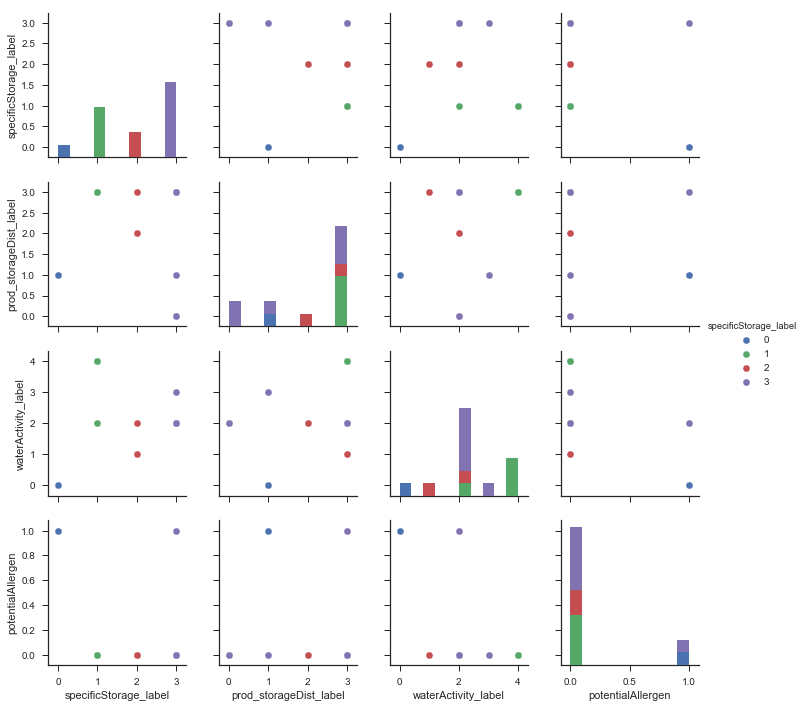

In [44]:
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")
sns.pairplot(train_df[['specificStorage_label','prod_storageDist_label','waterActivity_label','potentialAllergen']],hue='specificStorage_label')

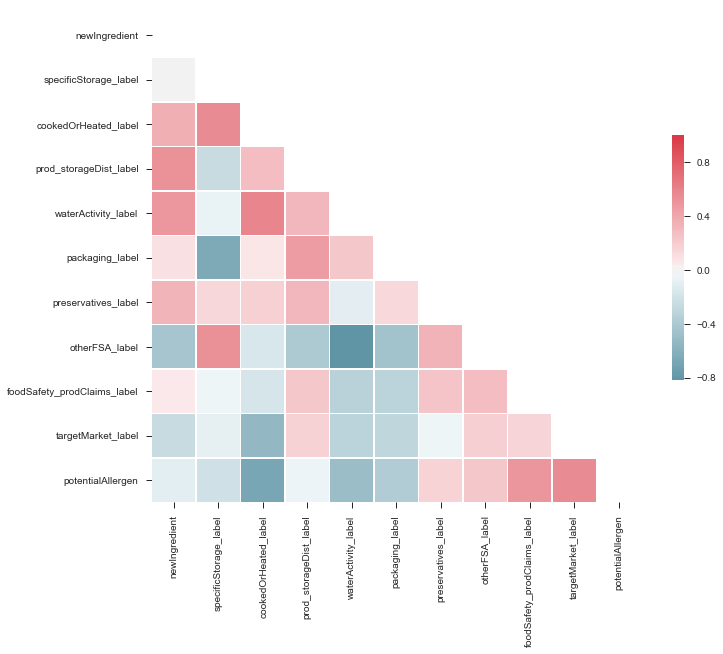

In [45]:
corr=train_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

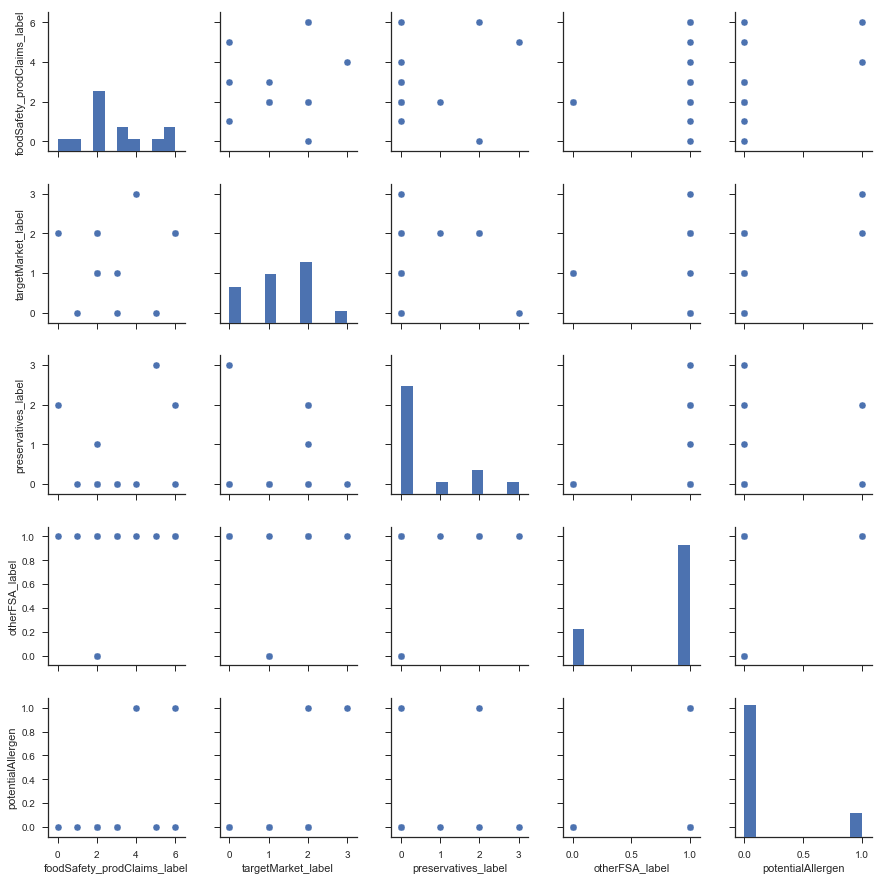

In [47]:
sns.pairplot(train_df[['foodSafety_prodClaims_label','targetMarket_label','preservatives_label','otherFSA_label','potentialAllergen']])